# MIS Divergence

In [1]:
import numpy as np
import math
from scipy import integrate, stats
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "amsmath",
    "font.sans-serif": "Helvetica",
})

## Generic part

In [3]:
# balance heuristic divergence
def bh_div(alpha, p1, p2):
    return alpha * p1 + (1 - alpha) * p2

def bh_div_weight(alpha, p1, p2):
    return (alpha * p1) / (alpha * p1 + (1 - alpha) * p2)

In [4]:
# computed variance for specific method
# TODO : check variance V[F] formula
def var_method(samples, fpdfs, gpdfs, alpha):
    
    v_sum_squared = 0
    v_sum = 0
    
    for i, spp in enumerate(samples):
        
        v_sum_squared += (spp ** 2) / (bh_div(alpha, fpdfs[i], gpdfs[i]) ** 2)
        v_sum += (spp / bh_div(alpha, fpdfs[i], gpdfs[i]))
        
    v_sum_squared /= len(samples)
    v_sum /= len(samples)
    
    return alpha * (v_sum_squared - (v_sum ** 2))

def sample(f, sampling1, sampling2, pdf_f1, pdf_f2, alpha):
    
    f_sum = 0
    
    # sample using first method
    x1 = sampling1()
    
    fpdf_1 = pdf_f1(x1)
    gpdf_1 = pdf_f2(x1)
    
    f1 = f(x1)
    
    # use of MIS weight for sampling1 function
    f_sum += f1 * bh_div_weight(alpha, fpdf_1, gpdf_1)
    
    # sample using second method
    x2 = sampling2()
    
    # TODO: check reverse PDFs or not?
    fpdf_2 = pdf_f2(x2)
    gpdf_2 = pdf_f1(x2)
    
    f2 = f(x2)
    
    # use of MIS weight for sampling2 function
    f_sum += f2 * bh_div_weight(1 - alpha, fpdf_2, gpdf_2)
    
    # final contribution is f_sum
    return f_sum, f1, f2, fpdf_1, gpdf_1, fpdf_2, gpdf_2 

In [5]:
def sampling_checker(sampling_f, begin, end):
    
    x = sampling_f()
    return x if x >= begin and x < end else sampling_checker(sampling_f, begin, end)

In [6]:
from sklearn.neighbors import KernelDensity

def compute_pdf(nsamples, interval, f, nbins=1000):

    nsamples += 1
    begin, end = interval
    samples = np.random.uniform(begin, end, nsamples)
    y = f(samples)
    counts, bin_edges = np.histogram(y, bins=nbins, density=True)
    
    X = np.concatenate(
        (samples, y)
    )[:, np.newaxis]
    
    X_plot = np.linspace(begin, end, nsamples)[:, np.newaxis]
    kde = KernelDensity(kernel='tophat', bandwidth=0.2).fit(X)
    log_dens = kde.score_samples(X_plot)
    
    #fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    
    #print(X_plot[:, 0].shape, log_dens.shape)
    
    #plt.plot(X_plot[:, 0], np.exp(log_dens))
    #plt.fill_between(X_plot[:, 0], np.exp(log_dens), alpha=0.2)
    #plt.title("Gaussian Kernel Density")

    #print(counts.sum())
    #print(counts / counts.sum())
    #print(bin_edges)

In [7]:
def get_discrete_pdf(f1, interval, nsamples, nbins):
    begin, end = interval
    samples = np.random.uniform(begin, end, nsamples)
    y = f1(samples)
    counts, bin_edges = np.histogram(y, bins=nbins, density=True)
    # plt.hist(bin_edges[:-1], bin_edges, weights=counts)
    def _get_pdf(sample):
        index = np.argmin(np.abs(bin_edges[1:] - sample))
        return counts[index - 1]

    return _get_pdf

pdf_f = get_discrete_pdf(lambda x: 2 - x, [0.01, math.pi / 2], 10000000, 10000)
pdf_f(0.4)

0.6195556640373205

### Example 1

In [8]:
def example_1(x):
    return math.sqrt(x) + math.sin(x)

In [9]:
# get example1 integral from [0.01, 3.5 * \pi] of PDFs
I = integrate.quad(example_1, 0.01, 3.5 * math.pi) 
print(f"Expected integral is: {I[0]}")

Expected integral is: 25.306521511962696


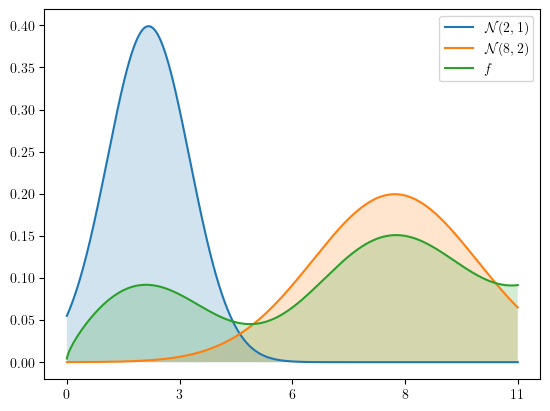

In [10]:
n_spp = 1001 # keep the closure interval
samples = np.linspace(0.01, 3.5 * math.pi, n_spp)
x = np.arange(n_spp)

f1_pdfs = stats.norm.pdf(samples, 2, 1)
f2_pdfs = stats.norm.pdf(samples, 8, 2)
example_samples = np.array([ example_1(spp) for spp in samples ])
mu_pdfs = example_samples / I[0]

plt.plot(f1_pdfs, label=r"$\mathcal{N}(2, 1)$")
plt.fill_between(x, f1_pdfs, alpha=0.2)
plt.plot(f2_pdfs, label=r"$\mathcal{N}(8, 2)$")
plt.fill_between(x, f2_pdfs, alpha=0.2)
plt.plot(mu_pdfs, label=r"$f$")
plt.fill_between(x, mu_pdfs, alpha=0.2)

frequency=250
plt.xticks(x[::frequency], [ f"{xi:.0f}" for xi in samples[::frequency]] )
plt.legend()

### Example 2

In [11]:
def example_2(x):
    return stats.norm.pdf(x, -1.5, 1) + 2 * stats.norm.pdf(x, 1.5, 0.75)

In [12]:
# get example2 intergal from [-4, 4] of PDFs
I = integrate.quad(example_2, -4, 4) 
print(f"Expected integral is: {I[0]}")

Expected integral is: 2.9929321950180436


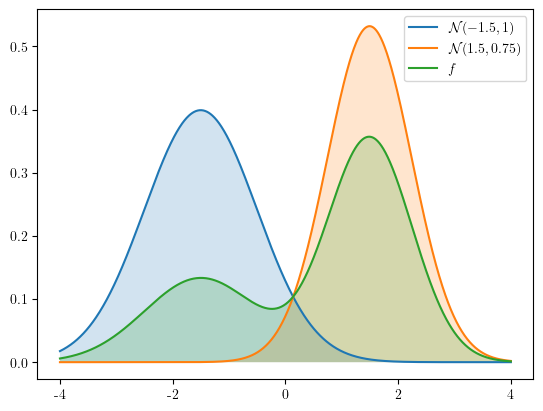

In [13]:
n_spp = 1001 # keep the closure interval
samples = np.linspace(-4, 4.01, n_spp)
x = np.arange(n_spp)

f1_pdfs = stats.norm.pdf(samples, -1.5, 1)
f2_pdfs = stats.norm.pdf(samples, 1.5, 0.75)
example_samples = np.array([ example_2(spp) for spp in samples ])
mu_pdfs = example_samples / I[0]

plt.plot(f1_pdfs, label=r"$\mathcal{N}(-1.5, 1)$")
plt.fill_between(x, f1_pdfs, alpha=0.2)
plt.plot(f2_pdfs, label=r"$\mathcal{N}(1.5, 0.75)$")
plt.fill_between(x, f2_pdfs, alpha=0.2)
plt.plot(mu_pdfs, label=r"$f$")
plt.fill_between(x, mu_pdfs, alpha=0.2)

frequency = 250
plt.xticks(x[::frequency], [ f"{xi:.0f}" for xi in samples[::frequency]] )
plt.legend()

### Example 3

In [14]:
def example_3(x):
    return math.sqrt(x) + math.sin(x)

In [15]:
# get example3 intergal from [0.01, \pi / 2] of PDFs
I = integrate.quad(example_3, 0.01, math.pi / 2) 
print(f"Expected integral is: {I[0]}")

Expected integral is: 2.311750829226866


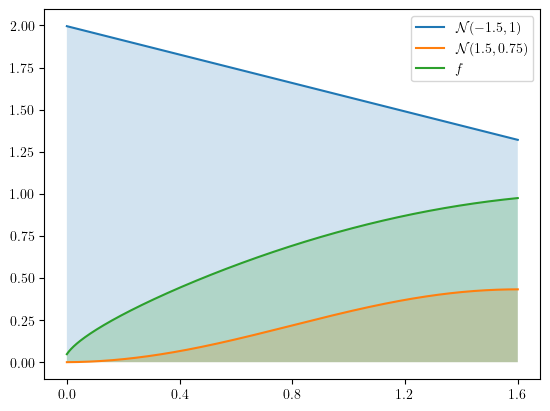

In [16]:
n_spp = 1001 # keep the closure interval
samples = np.linspace(0.01, math.pi / 2, n_spp)
x = np.arange(n_spp)

#f1_pdf_function = get_discrete_pdf(lambda x: 2 - x, [0.01, math.pi / 2], 1000000, 10000)
#f2_pdf_function = get_discrete_pdf(lambda x: np.sin(x) ** 2, [0.01, math.pi / 2], 1000000, 10000)
#f1_pdfs = np.array([ f1_pdf_function(sample) for sample in samples ]) / I[0]# 2 - x
#f2_pdfs = np.array([ f2_pdf_function(sample) for sample in samples ]) / I[0] # sin²(x)

f1_pdfs = 2 - samples / I[0]
f2_pdfs = (np.sin(samples) ** 2) / I[0]
example_samples = np.array([ example_3(spp) for spp in samples ])
mu_pdfs = example_samples / I[0]

plt.plot(f1_pdfs, label=r"$\mathcal{N}(-1.5, 1)$")
plt.fill_between(x, f1_pdfs, alpha=0.2)
plt.plot(f2_pdfs, label=r"$\mathcal{N}(1.5, 0.75)$")
plt.fill_between(x, f2_pdfs, alpha=0.2)
plt.plot(mu_pdfs, label=r"$f$")

plt.fill_between(x, mu_pdfs, alpha=0.2)

frequency=250
plt.xticks(x[::frequency], [ f"{xi:.1f}" for xi in samples[::frequency]] )
plt.legend()

In [17]:
f1_pdfs = compute_pdf(10000, [0.01, math.pi / 2], lambda x: 2 - x, 10)

### Example 4

In [18]:
def example_4(x):
    return stats.norm.pdf(x, 1.8, 1) + 2 * stats.norm.pdf(x, 1.5, 0.75) + 3 * stats.norm.pdf(x, -0.5, 0.5)

In [19]:
# get example3 intergal from [0.01, \pi / 2] of PDFs
I = integrate.quad(example_4, -3, 3) 
print(f"Expected integral is: {I[0]}")

Expected integral is: 5.839428410622051


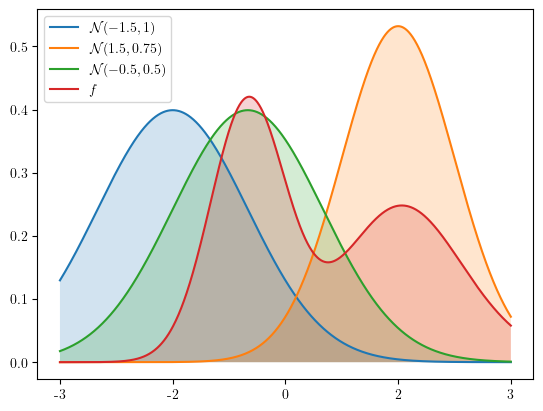

In [20]:
n_spp = 1001 # keep the closure interval
samples = np.linspace(-3, 3, n_spp)
x = np.arange(n_spp)

f1_pdfs = stats.norm.pdf(samples, -1.5, 1)
f2_pdfs = stats.norm.pdf(samples, 1.5, 0.75)
f3_pdfs = stats.norm.pdf(samples, -0.5, 1)
example_samples = np.array([ example_4(spp) for spp in samples ])
mu_pdfs = example_samples / I[0]

plt.plot(f1_pdfs, label=r"$\mathcal{N}(-1.5, 1)$")
plt.fill_between(x, f1_pdfs, alpha=0.2)
plt.plot(f2_pdfs, label=r"$\mathcal{N}(1.5, 0.75)$")
plt.fill_between(x, f2_pdfs, alpha=0.2)
plt.plot(f3_pdfs, label=r"$\mathcal{N}(-0.5, 0.5)$")
plt.fill_between(x, f3_pdfs, alpha=0.2)
plt.plot(mu_pdfs, label=r"$f$")
plt.fill_between(x, mu_pdfs, alpha=0.2)

frequency=250
plt.xticks(x[::frequency], [ f"{xi:.0f}" for xi in samples[::frequency]] )
plt.legend()

### Prepare MIS (equal sampling) for example 1

In [21]:
# use interval checker of integration
f1 = lambda: sampling_checker((lambda: np.random.normal(2, 1)), 0.01, 3.5 * math.pi) 
f2 = lambda: sampling_checker((lambda: np.random.normal(8, 2)), 0.01, 3.5 * math.pi) 
pdf_f1 = lambda x: stats.norm.pdf(x, 2, 1)
pdf_f2 = lambda x: stats.norm.pdf(x, 8, 2)
alpha = 0.5

In [22]:
s_list = []
f1_list = []
f2_list = []
fpdf1_list = []
gpdf1_list = []
fpdf2_list = []
gpdf2_list = []

for i in range(10000):
    
    s, f1_s, f2_s, fpdf1, gpdf1, fpdf2, gpdf2 = sample(example_1, f1, f2, pdf_f1, pdf_f2, alpha)
    
    s_list.append(s)
    f1_list.append(f1_s)
    f2_list.append(f2_s)
    fpdf1_list.append(fpdf1)
    gpdf1_list.append(gpdf1)
    fpdf2_list.append(fpdf2)
    gpdf2_list.append(gpdf2)

In [23]:
VF_sum = 0

VF_sum += var_method(f1_list, fpdf1_list, gpdf1_list, 0.5)
VF_sum += var_method(f2_list, fpdf2_list, gpdf2_list, 0.5)
print(VF_sum)

26.62214762593331


### Prepare MIS (equal sampling) for example 2

In [24]:
f1 = lambda: np.random.normal(-1.5, 1)
f2 = lambda: np.random.normal(1.5, 0.75)
pdf_f1 = lambda x: stats.norm.pdf(x, -1.5, 1)
pdf_f2 = lambda x: stats.norm.pdf(x, 1.5, 0.75)
alpha = 0.5

In [25]:
s_list = []
f1_list = []
f2_list = []
fpdf1_list = []
gpdf1_list = []
fpdf2_list = []
gpdf2_list = []

for i in range(10000):
    
    s, f1_s, f2_s, fpdf1, gpdf1, fpdf2, gpdf2 = sample(example_2, f1, f2, pdf_f1, pdf_f2, alpha)
    
    s_list.append(s)
    f1_list.append(f1_s)
    f2_list.append(f2_s)
    fpdf1_list.append(fpdf1)
    gpdf1_list.append(gpdf1)
    fpdf2_list.append(fpdf2)
    gpdf2_list.append(gpdf2)

In [26]:
VF_sum = 0

VF_sum += var_method(f1_list, fpdf1_list, gpdf1_list, 0.5)
VF_sum += var_method(f2_list, fpdf2_list, gpdf2_list, 0.5)
print(VF_sum)

0.11583959450431269


In [27]:
# other links
# https://github.com/MJeremy2017/machine-learning-algorithm-implemention/blob/master/ImportanceSampling/ImportanceSampling.ipynb

### Try using divergences module

In [1]:
from divergences.model import TsallisImportance
import numpy as np
from scipy import stats

In [2]:
def example_2(x):
    return stats.norm.pdf(x, -1.5, 1) + 2 * stats.norm.pdf(x, 1.5, 0.75)

In [3]:
f1 = lambda: np.random.normal(-1.5, 1)
f2 = lambda: np.random.normal(1.5, 0.75)
pdf_f1 = lambda x: stats.norm.pdf(x, -1.5, 1)
pdf_f2 = lambda x: stats.norm.pdf(x, 1.5, 0.75)
alpha = 0.5

In [6]:
# using MIS expected 11.34
div_model = TsallisImportance(example_2, [f1, f2], [pdf_f1, pdf_f2], (-4, 4))

In [7]:
div_model.fit(samples=10000, batch=100)

[100 samples] variance: 26.8089
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[200 samples] variance: 198.3261
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[300 samples] variance: 353.1467
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[400 samples] variance: 0.4127
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[500 samples] variance: 379.9327
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[600 samples] variance: 0.2822
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[700 samples] variance: 523.3794
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[800 samples] variance: 13.6749
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[900 samples] variance: 116.1348
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[1000 samples] variance: 71.1505
Next update of alphas
[2.220446049250313e-16, 0.9999999999999998]
[1100 samples] v